In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
import tensorflow as tf
from lib.pinn import PINN
from lib.network import Network
from utilities import print_t
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True) 

In [3]:
from parameters import build_params
params = [
    build_params(1),
    build_params(2),
    build_params(3),
]
act = 'sigmoid'
layers=[100,100,100]
optimizer='adam'
loss='mse'
path = f"models/l={layers} act={act} opt={optimizer} loss={loss}"

In [ ]:
networks = [
    tf.keras.models.load_model(path+'/1'),
    tf.keras.models.load_model(path+'/2'),
    tf.keras.models.load_model(path+'/3'),
]

In [4]:
networks = [
    Network.build(layers=layers, activation=act, **p) for p in params
]

In [5]:
pinns = [PINN(n, **p).build(**p) for n, p in zip(networks, params)]
for pinn in pinns:
    pinn.compile(optimizer=optimizer, loss=loss)

In [12]:
def save(net):
    p = path + f"/{net.layers[0].output_shape[-1][-1]-1}"
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)
    net.save(p)

In [13]:
for net in networks:
    save(net)

INFO:tensorflow:Assets written to: models/l=[100, 100, 100] act=sigmoid opt=adam loss=mse/1\assets
INFO:tensorflow:Assets written to: models/l=[100, 100, 100] act=sigmoid opt=adam loss=mse/2\assets
INFO:tensorflow:Assets written to: models/l=[100, 100, 100] act=sigmoid opt=adam loss=mse/3\assets


In [15]:
def train(pinn, p):
    n_train_samples = 5000000

    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]
    padding = size/10000


    def correct_bounds(x):
        for i in range(p["dim"]):
            x[(x[:, i] < min_d[i] + padding[i]) | (x[:, i] > max_d[i]-padding[i]), i] = (min_d + max_d)[i]/2


    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    correct_bounds(x_train)
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    # print(x_train_left)
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]

    # y = {name: np.zeros((n_train_samples, 1)) for name in ["eq1", "eq2", "eq3", "eq4",
    #                      "cl", "vl", "Fil",
    #                      "cr", "vr", "Fir",
    #                      "cs", "vs", "Fis"]}

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    pinn.fit(x=x, y=y)


In [ ]:
def train(pinn, p):
    n_train_samples = 5000000

    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]
    padding = size/10000


    def correct_bounds(x):
        for i in range(p["dim"]):
            x[(x[:, i] < min_d[i] + padding[i]) | (x[:, i] > max_d[i]-padding[i]), i] = (min_d + max_d)[i]/2


    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    correct_bounds(x_train)
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    # print(x_train_left)
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]

    # y = {name: np.zeros((n_train_samples, 1)) for name in ["eq1", "eq2", "eq3", "eq4",
    #                      "cl", "vl", "Fil",
    #                      "cr", "vr", "Fir",
    #                      "cs", "vs", "Fis"]}

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    pinn.fit(x=x, y=y)

In [16]:
for pinn, p in zip(pinns, params):
    train(pinn, p)

156250/156250 [==============================] - 361s 2ms/step - loss: 0.0447 - tf.__operators__.add_8_loss: 0.0030 - tf.__operators__.add_9_loss: 0.0024 - tf.__operators__.add_11_loss: 0.0262 - tf.math.subtract_12_loss: 1.6224e-04 - tf.math.subtract_13_loss: 0.0046 - tf.math.subtract_14_loss: 1.3770e-04 - tf.math.subtract_15_loss: 0.0048 - tf.math.subtract_16_loss: 0.0012 - tf.math.subtract_17_loss: 0.0021


In [17]:
def test(network, p, num_test_samples = 30):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    # print(dims)
    dims = np.split(dims.flatten(), p["dim"]+1)
    # print(dims)
    mdims = np.meshgrid(*dims, indexing='ij')
    # print(mdims)
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    # print(txyz)
    return [dims, mdims] + network.predict(txyz, batch_size=num_test_samples)

In [18]:
res = [test(net, p) for net, p in zip(networks, params)]


27000/27000 [==============================] - 15s 555us/step


In [21]:
def plot_c(fig, i, p, dims, mdims, c):
    c = c.reshape(mdims[0].shape)

    axc = fig.add_subplot(131 + i)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    for t in [1,2,5,10,20]:
        axc.plot(dims[1], c[(t, slice(None),) + other_dim], label=f't={t}')

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)



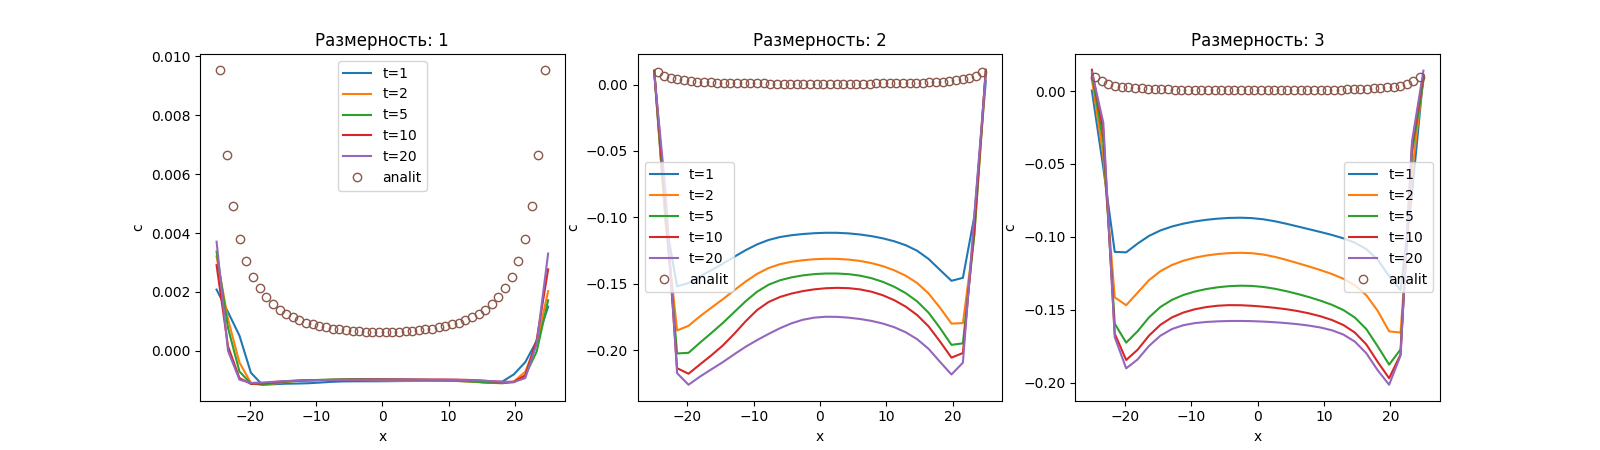

In [22]:
fig = plt.figure(figsize=(16, 4.5))
for i, (r, p) in enumerate(zip(res, params)):
    plot_c(fig, i, p, r[0], r[1], r[2])
plt.show()
 

In [ ]:
c = c.reshape(mdims[0].shape)
time_t = 20
fig = plt.figure(figsize=(16, 4.5))

ax1 = fig.add_subplot(131,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax1.plot_surface(*np.meshgrid(dims[1], dims[2], indexing='ij'), c[0,...,int(p["size"][3]/2)])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("c")

ax2 = fig.add_subplot(132,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax2.plot_surface(*np.meshgrid(dims[1], dims[2], indexing='ij'), c[10,...,int(p["size"][3]/2)])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("c")

ax3 = fig.add_subplot(133,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax3.plot_surface(*np.meshgrid(dims[1], dims[2], indexing='ij'), c[20,...,int(p["size"][3]/2)])
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("c")

plt.show()


In [ ]:
v = v.reshape(mdims[0].shape+(-1,))
fig = plt.figure(figsize=(16, 4.5))

ax1 = fig.add_subplot(131)
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax1.plot(dims[1], v[(0, slice(None),) + other_dim + (0,)], label="x")
ax1.plot(dims[1], v[(0, slice(None),) + other_dim + (1,)], label="y")
ax1.plot(dims[1], v[(0, slice(None),) + other_dim + (2,)], label="z")
ax1.plot(analit[:,0], analit[:,2], 'o', mfc="none", label="analit")
ax1.set_xlabel("x")
ax1.set_ylabel("v")
# ax1.set_ylim(0, 0.04)
ax1.legend(loc='best')

# ax2 = fig.add_subplot(132)
# # ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
# ax2.plot(dims[1], v[-1,:, 0, 0, 0], label="x")
# ax2.plot(dims[1], v[-1,:, 0, 0, 1], label="y")
# ax2.plot(dims[1], v[-1,:, 0, 0, 2], label="z")
# ax2.set_xlabel("x")
# ax2.set_ylabel("v")
# ax2.set_ylim(0, 0.04)
# ax2.legend(loc='best')


In [ ]:
network(tf.constant([[0.,0.,dims[2][1]]]))

In [ ]:
r = pinn([tf.constant([[0.,p["min_dim"][1],0.,0]])]*4)
[res.numpy() for res in r]

In [ ]:
c[0,-1,1]

In [ ]:
network(np.array([[p["max_t"], p["max_x"], p["max_y"], p["max_z"]]]))

In [ ]:
np.meshgrid(np.zeros(2), np.zeros(3))

In [ ]:
n_test_samples = 2
max_d = np.array([p["max_t"], p["max_x"], p["max_y"], p["max_z"]])
x_train = np.random.rand(n_test_samples, 4) * max_d
x_train_left = np.random.rand(n_test_samples, 4) * max_d
x_train_left[:,1] = 0
x_train_right = np.random.rand(n_test_samples, 4) * max_d
x_train_right[:,1] = 0
x=[x_train, x_train_left, x_train_right]
for i, xx in enumerate(pinn(x)):
    print(i, ":", xx.shape)
